In [44]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# DATAPATH = "data"

In [66]:
heart = pd.read_csv(os.path.join("heart.csv"))
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Encoding of binary variables

In [41]:

enc = LabelEncoder()
heart_cat = heart.apply(enc.fit_transform)
heart_cat

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,41,147,0,1,98,0,10,2,0
1,21,0,2,55,40,0,1,82,0,20,1,1
2,9,1,1,31,141,0,2,25,0,10,2,0
3,20,0,0,39,72,0,1,34,1,25,1,1
4,26,1,2,49,53,0,1,48,0,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,17,1,3,14,122,0,1,58,0,22,1,1
914,40,1,0,45,51,1,1,67,0,42,1,1
915,29,1,0,31,9,0,1,41,1,22,1,1
916,29,0,1,31,94,0,0,100,0,10,1,1


# Mask Cholesterol 0 with mean

In [ ]:
heart_cat['Cholesterol'].mask(heart_cat['Cholesterol']==0,heart_cat['Cholesterol'].mean(),inplace=True)
heart_cat

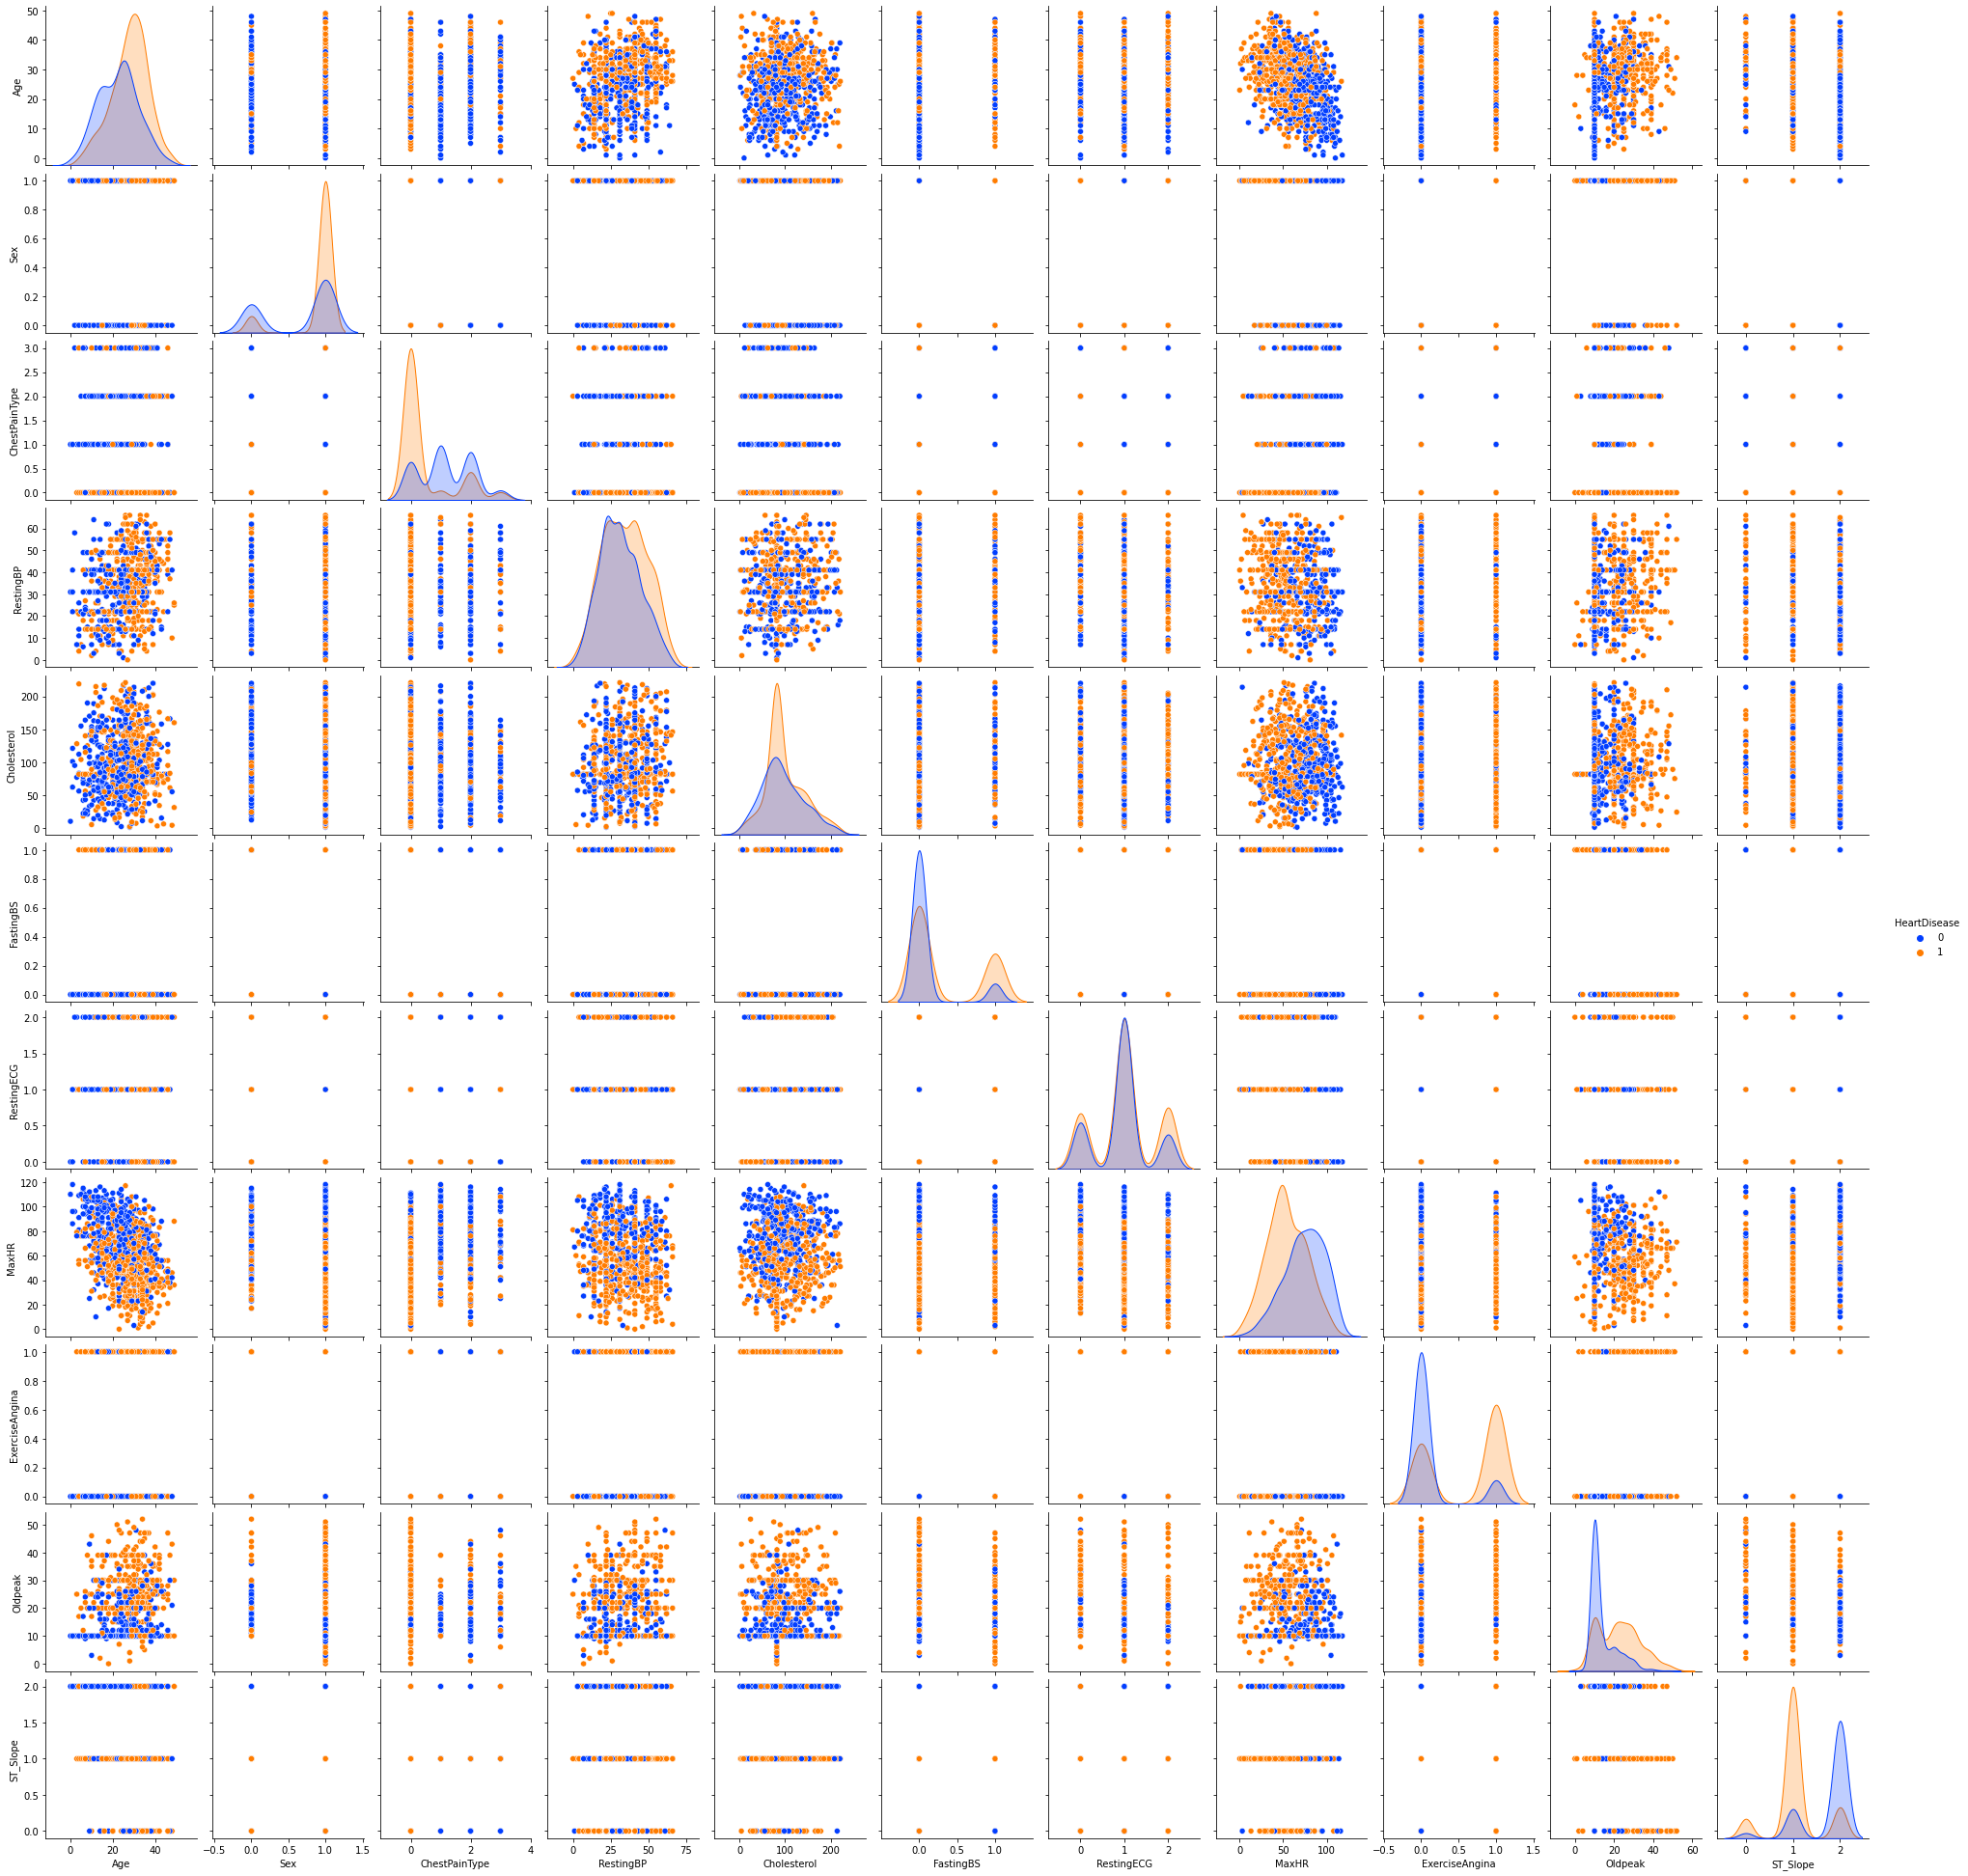

In [55]:
sns.pairplot(heart_cat, hue="HeartDisease", palette="bright")

In [54]:
corr = heart_cat.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
Age,1.000000,0.055750,-0.077150,0.274459,0.042967,0.198039,-0.007484,-0.383374,0.215793,0.266295,-0.268264,0.282039
Sex,0.055750,1.000000,-0.126559,0.018717,-0.128736,0.120076,0.071552,-0.189878,0.190664,0.116254,-0.150693,0.305445
ChestPainType,-0.077150,-0.126559,1.000000,-0.011818,-0.075697,-0.073151,-0.072537,0.291560,-0.354727,-0.180408,0.213521,-0.386828
RestingBP,0.274459,0.018717,-0.011818,1.000000,0.099786,0.064806,0.026082,-0.109674,0.158825,0.174026,-0.074377,0.113658
Cholesterol,0.042967,-0.128736,-0.075697,0.099786,1.000000,-0.017063,-0.098358,0.033947,0.081451,0.070522,-0.035384,0.045652
FastingBS,0.198039,0.120076,-0.073151,0.064806,-0.017063,1.000000,0.087050,-0.131018,0.060451,0.069180,-0.175774,0.267291
RestingECG,-0.007484,0.071552,-0.072537,0.026082,-0.098358,0.087050,1.000000,-0.179168,0.077500,-0.015096,-0.006778,0.057384
MaxHR,-0.383374,-0.189878,0.291560,-0.109674,0.033947,-0.131018,-0.179168,1.000000,-0.376149,-0.176992,0.346587,-0.402627
ExerciseAngina,0.215793,0.190664,-0.354727,0.158825,0.081451,0.060451,0.077500,-0.376149,1.000000,0.422670,-0.428706,0.494282
Oldpeak,0.266295,0.116254,-0.180408,0.174026,0.070522,0.069180,-0.015096,-0.176992,0.422670,1.000000,-0.513817,0.420282


In [68]:
heart_int = heart[heart.describe().columns]
heart_int['Cholesterol'].mask(heart_int['Cholesterol']==0,heart_int['Cholesterol'].mean(),inplace=True)
heart_int

C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,140,289.0,0,172,0.0,0
1,49,160,180.0,0,156,1.0,1
2,37,130,283.0,0,98,0.0,0
3,48,138,214.0,0,108,1.5,1
4,54,150,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...
913,45,110,264.0,0,132,1.2,1
914,68,144,193.0,1,141,3.4,1
915,57,130,131.0,0,115,1.2,1
916,57,130,236.0,0,174,0.0,1


# Simpler classifiers
## 1.  KNN with categorical variables encoded, continuous values + Chrolesterol==0 masked with mean

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix

y = heart_cat['HeartDisease']
X = heart_cat.drop('HeartDisease',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [109]:
parameters = dict(n_neighbors=range(1,200))
knn = KNeighborsClassifier()
gridSearch = GridSearchCV(knn,parameters)
gridSearch.fit(X_train.values,y_train.values)
print("Best Score knn: "+str(gridSearch.best_score_))
prediction = gridSearch.predict(X_test.values)
test_accuracy = accuracy_score(y_test,prediction)
print("Test accuracy: "+str(test_accuracy))


Best Score knn: 0.7382113821138211
Test accuracy: 0.7260726072607261


In [119]:
pd.DataFrame(gridSearch.cv_results_).head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002201,0.000749,0.006397,0.002579,1,{'n_neighbors': 1},0.674797,0.715447,0.723577,0.707317,0.666667,0.697561,0.022648,184
1,0.001799,0.000746,0.006001,0.001674,2,{'n_neighbors': 2},0.634146,0.674797,0.691057,0.682927,0.682927,0.673171,0.020178,199
2,0.003001,0.002607,0.009597,0.004364,3,{'n_neighbors': 3},0.764228,0.739837,0.715447,0.707317,0.699187,0.725203,0.023787,25
3,0.001402,0.000801,0.004599,0.000801,4,{'n_neighbors': 4},0.723577,0.739837,0.723577,0.715447,0.707317,0.721951,0.010786,43
4,0.001000,0.000001,0.005000,0.001265,5,{'n_neighbors': 5},0.747967,0.747967,0.723577,0.772358,0.682927,0.734959,0.030246,2
5,0.001010,0.000017,0.004998,0.000893,6,{'n_neighbors': 6},0.747967,0.731707,0.731707,0.747967,0.699187,0.731707,0.017812,11


C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


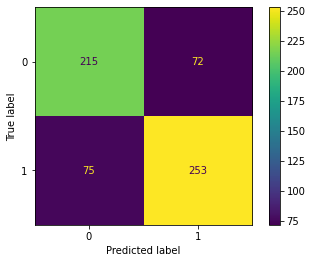

In [110]:
plot_confusion_matrix(gridSearch,X_train.values,y_train, values_format="d")

C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


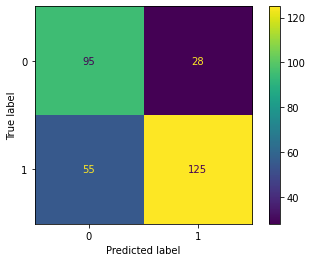

In [111]:
plot_confusion_matrix(gridSearch,X_test.values,y_test, values_format="d")

## 2.  SVM with only continuous values + Chrolesterol==0 masked with mean

In [120]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["poly"], "degree": [2, 3]},
    {"kernel": ["rbf"]},
]

svc = SVC(random_state=0)

search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="roc_auc")
search.fit(X_train.values, y_train)
print("Best Score svc: "+str(search.best_score_))
prediction = search.predict(X_test.values)
test_accuracy = accuracy_score(y_test,prediction)
print("Test accuracy: "+str(test_accuracy))

Best Score knn: 0.900374116708055
Test accuracy: 0.8448844884488449


In [113]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.871819,0.173454,0.003787,0.001817,linear,NaN,{'kernel': 'linear'},0.947368,0.917331,0.891813,0.866578,0.878780,0.900374,0.028906,1
1,0.007406,0.001043,0.003396,0.000792,poly,2,"{'degree': 2, 'kernel': 'poly'}",0.870016,0.844763,0.803828,0.783554,0.796552,0.819743,0.032416,2
2,0.008201,0.000972,0.002192,0.000396,poly,3,"{'degree': 3, 'kernel': 'poly'}",0.866560,0.845029,0.810739,0.764987,0.781963,0.813856,0.037854,4
3,0.010393,0.000806,0.005201,0.000401,rbf,NaN,{'kernel': 'rbf'},0.853270,0.835991,0.808612,0.794164,0.800531,0.818514,0.022484,3


C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


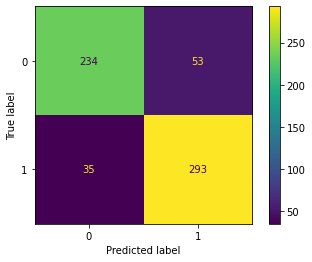

In [123]:
plot_confusion_matrix(search,X_train.values,y_train, values_format="d")

C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


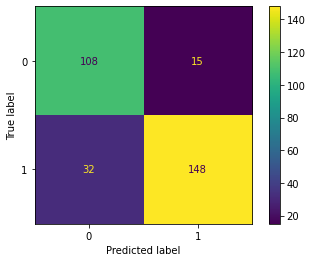

In [124]:
plot_confusion_matrix(search,X_test.values,y_test, values_format="d")

## 3. KNN with only numerical + Cholesterol == 0 masked with the mean

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix

y = heart_int['HeartDisease']
X = heart_int.drop('HeartDisease',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [131]:
parameters = dict(n_neighbors=range(1,200))
knn = KNeighborsClassifier()
gridSearch_int = GridSearchCV(knn,parameters)
gridSearch_int.fit(X_train.values,y_train.values)
print("Best Score knn: "+str(gridSearch_int.best_score_))
prediction = gridSearch_int.predict(X_test.values)
test_accuracy = accuracy_score(y_test,prediction)
print("Test accuracy: "+str(test_accuracy))


Best Score knn: 0.7008130081300814
Test accuracy: 0.6732673267326733


In [132]:
pd.DataFrame(gridSearch_int.cv_results_).head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002198,0.000749,0.008801,0.001170,1,{'n_neighbors': 1},0.674797,0.658537,0.674797,0.601626,0.626016,0.647154,0.028905,192
1,0.001601,0.000802,0.005999,0.001099,2,{'n_neighbors': 2},0.585366,0.569106,0.658537,0.617886,0.577236,0.601626,0.032924,199
2,0.002599,0.002331,0.008601,0.001493,3,{'n_neighbors': 3},0.699187,0.658537,0.658537,0.666667,0.626016,0.661789,0.023338,164
3,0.002200,0.000749,0.008399,0.004454,4,{'n_neighbors': 4},0.626016,0.658537,0.642276,0.626016,0.593496,0.629268,0.021572,198
4,0.001400,0.000489,0.004199,0.000748,5,{'n_neighbors': 5},0.699187,0.699187,0.682927,0.658537,0.626016,0.673171,0.027880,122
5,0.000600,0.000490,0.004599,0.001356,6,{'n_neighbors': 6},0.682927,0.658537,0.674797,0.666667,0.634146,0.663415,0.016741,160


C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


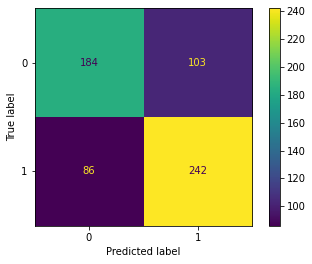

In [133]:
plot_confusion_matrix(gridSearch_int,X_train.values,y_train, values_format="d")

C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


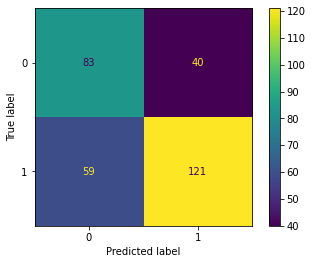

In [134]:
plot_confusion_matrix(gridSearch_int,X_test.values,y_test, values_format="d")

## 4. SVC with only numerical + Cholesterol == 0 masked with the mean

In [142]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

param_grid = [
    {"C":      [0.1, 0.5, 0.9, 1, 1.5, 2]},
    {"kernel": ["linear"]},
    {"kernel": ["poly"], "degree": [2, 3, 4, 5]},
    {"kernel": ["rbf"]},
]

svc_int = SVC(random_state=0)

search_int = GridSearchCV(estimator=svc_int, param_grid=param_grid, scoring="roc_auc")
search_int.fit(X_train.values, y_train)
print("Best Score svc: "+str(search_int.best_score_))
prediction = search_int.predict(X_test.values)
test_accuracy = accuracy_score(y_test,prediction)
print("Test accuracy: "+str(test_accuracy))

Best Score svc: 0.8345594997863601
Test accuracy: 0.735973597359736


In [139]:
pd.DataFrame(search_int.cv_results_).head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014401,0.001022,0.011600,2.573939e-03,0.1,NaN,NaN,{'C': 0.1},0.750399,0.774588,0.737374,0.753846,0.699469,0.743135,0.024886,12
1,0.010397,0.002942,0.007802,2.140162e-03,0.5,NaN,NaN,{'C': 0.5},0.751462,0.773259,0.737905,0.755172,0.705305,0.744621,0.022668,11
2,0.009599,0.000490,0.006001,3.873843e-07,0.9,NaN,NaN,{'C': 0.9},0.752791,0.771132,0.736045,0.757029,0.706366,0.744673,0.022184,10
3,0.009996,0.002282,0.007003,8.925511e-04,1,NaN,NaN,{'C': 1},0.754120,0.769537,0.736576,0.756764,0.707162,0.744832,0.021569,8
4,0.008798,0.000400,0.005602,1.200344e-03,1.5,NaN,NaN,{'C': 1.5},0.753057,0.768740,0.740032,0.759416,0.708488,0.745947,0.020927,6
5,0.007997,0.000002,0.006603,4.896642e-04,2,NaN,NaN,{'C': 2},0.755183,0.766879,0.740032,0.762069,0.712467,0.747326,0.019646,5


C:\Users\eloid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


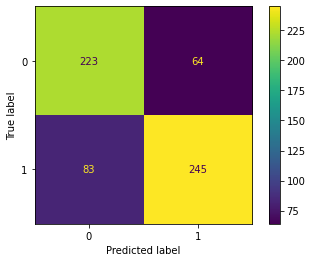

In [140]:
plot_confusion_matrix(search_int,X_train.values,y_train, values_format="d")